In [4]:
import sys
sys.path.append("../")
from helper import Data
from regressors import Regressor

c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\f

In [104]:
d = Data()

d.fetch_data()
pre_df = d.preprocess_data(d.df_us_cases)
df = d.daily_data(pre_df)
daily_reg = Regressor(df, 7)

In [144]:
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def ARIMA_mod(self, row='Total'):
    daily_df = self.daily_df.copy()
    params = [(i,j,k) for i in range(5,7) for j in range(3) for k in range(3)]
    min_aic = float("inf")
    final_model = None
    final_param = (6,2,2)
    for param in params:
        try:
            model = ARIMA(np.array(daily_df[row].tolist(), dtype=np.float32), order=param)
            model = model.fit()
            if model.aic<min_aic:
                min_aic=model.aic
                final_model = model
                final_param = param
            # break
        except Exception as e:
            print(e)
            continue

    model = final_model
    preds = model.predict(start = final_param[1], end = len(daily_df.index)-1)
    
    preds = np.array(preds) + np.array(daily_df[row].tolist())[final_param[1]:]
    print(preds.tolist())
    real, _, intervals = model.forecast(self.forecast_interval)
    preds = np.append(preds, real)

    forecasted_days = self.generate_dates(daily_df.index[-1], self.forecast_interval)
    preds = pd.DataFrame(data=preds, columns=["forecast"], index=daily_df.index[final_param[1]:].union(forecasted_days))
    interval_low = pd.DataFrame(data=intervals[:,0], columns=["interval_low"], index=forecasted_days)
    interval_high = pd.DataFrame(data=intervals[:,1], columns=["interval_high"], index=forecasted_days)

    daily_df = pd.concat([daily_df, preds, interval_low, interval_high], axis=1)

    return model, preds

In [145]:
arima, preds = ARIMA_mod(daily_reg)

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not converge
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not converge
SVD did not converge
[4.128123547298105, 9.8210970105576, 4.801710621075221, 10.56032638985091, 10.163154459197541, 16.775076544160715, 30.415041017441798, 34.41653992288463, 42.028795565708336, 44.99572804385426, 38.23112623505082, 47.26209718747323, 44.25069402057493, 44.649135494822275, 43.654597898770575, 44.09899073

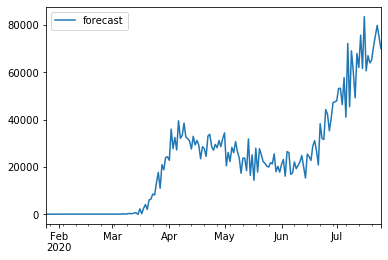

In [146]:
preds.plot()

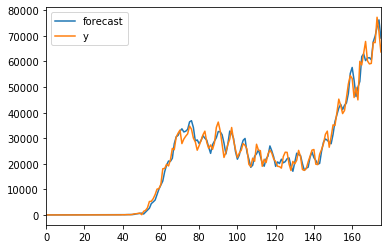

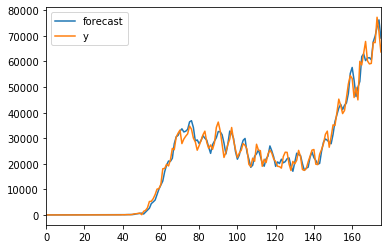

In [137]:
# np.set_printoptions(precision=3, suppress=False)
import matplotlib.pyplot as plt
%matplotlib inline
arima.plot_predict()

In [127]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  176
Model:                 ARIMA(6, 2, 1)   Log Likelihood               -1607.906
Method:                       css-mle   S.D. of innovations           2203.056
Date:                Sun, 19 Jul 2020   AIC                           3233.812
Time:                        22:49:44   BIC                           3262.346
Sample:                             2   HQIC                          3245.385
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1281     15.976      0.258      0.796     -27.184      35.440
ar.L1.D2.y    -0.9021      0.080    -11.309      0.000      -1.058      -0.746
ar.L2.D2.y    -0.7786      0.081     -9.666      0.000      -0.936      -0.621
ar.L3.D2.y    -0.8166      0.068    -12.088      0.000      -0.949      -0.684
ar.L4.D2.y    -0.9002      0.066    -13.628      0.000      -1.030      -0.771
ar.L5.D2.y    -0.8758      0.078    -11.276      0.000      -1.028      -0.724
ar.L6.D2.y    -0.5532      0.074     -7.474      0.000      -0.698      -0.408
ma.L1.D2.y    -0.4514      0.079     -5.714      0.000      -0.606      -0.297
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6232           -0.8028j            1.0164           -0.1449
AR.2            0.6232           +0.8028j            1.0164            0.1449
AR.3           -0.3444           -1.0804j            1.1340           -0.2991
AR.4           -0.3444           +1.0804j            1.1340            0.2991
AR.5           -1.0705           -0.4637j            1.1666           -0.4349
AR.6           -1.0705           +0.4637j            1.1666            0.4349
MA.1            2.2154           +0.0000j            2.2154            0.0000
-----------------------------------------------------------------------------
"""

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
def LSTM_rep(self, model, lookback=7, row='Total', num_estimators=10):
    daily_df = self.daily_df.copy()
    scaler = MinMaxScaler()
    train = daily_df[row].tolist()
    train = np.array(train).reshape((-1, 1))
    train = scaler.fit_transform(train)
    train = train.ravel()

    x_train, y_train = [], []
    for i in range(len(train) - lookback - 7 + 1):
        x = train[i:i + lookback]
        x_train.append(x)
        y_train.append(train[i + lookback:i + lookback + 7])

    train_pred = []
    for i in range(len(train)-lookback+1):
        train_pred.append(train[i:i+lookback])

    train_pred = np.array(train_pred)
    train_pred = train_pred.reshape((train_pred.shape[0], train_pred.shape[1], 1))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    arr = scaler.inverse_transform(model.predict(x_train))
#     arr = arr.ravel()
#     print(arr)
    print(np.diff(arr))
    plt.plot(np.diff(arr))

[[  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638

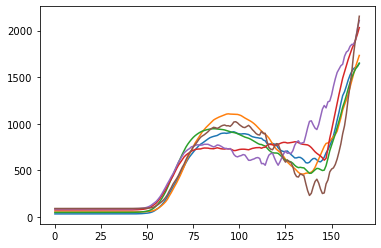

In [66]:
LSTM_rep(daily_reg, lstm, row="North Carolina")

In [81]:
temp = df["Total"]
temp.argmax()

c:\users\sheel\pycharmprojects\adbi\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


Timestamp('2020-07-16 00:00:00')

In [89]:
temp.dropna()

2020-01-23        0.0
2020-01-24        1.0
2020-01-25        0.0
2020-01-26        3.0
2020-01-27        0.0
               ...   
2020-07-14    67417.0
2020-07-15    67328.0
2020-07-16    77255.0
2020-07-17    71558.0
2020-07-18    63698.0
Name: Total, Length: 178, dtype: float64